## 0. Imports Preliminaries

In [1]:
!pip install nltk readability-lxml readability spacy keras==2.8

In [2]:
#0. Preliminaries
import pandas as pd
import nltk
nltk.download('punkt')
#from readability import Readability

[nltk_data] Downloading package punkt to /home/lluneta/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import string
import numpy as np
from sklearn.model_selection import train_test_split
import re
import spacy

In [4]:
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/lluneta/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [5]:
from transformers import pipeline
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("lxyuan/distilbert-base-multilingual-cased-sentiments-student", max_length = 512, truncation = True)

distilled_student_sentiment_classifier = pipeline(
    model="lxyuan/distilbert-base-multilingual-cased-sentiments-student",
    tokenizer = tokenizer,
    return_all_scores=True
)

2023-12-08 19:41:31.344916: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-08 19:41:31.489316: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-12-08 19:41:31.489339: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-12-08 19:41:31.525589: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-08 19:41:32.120319: W tensorflow/stream_executor/platform/de

## 1. Load Data

In [6]:
#1. Import Data
df = pd.read_csv("../data/chunked_author_data.csv")

In [7]:
df_train_val, df_test = train_test_split(df, train_size = 0.8, random_state = 42)
df_train, df_val = train_test_split(df_train_val, train_size = 0.8, random_state = 42)

## 2. Clean Data 

In [8]:
def regex(string: str):
    """
    Function that applies regular expressions to a string based on the specified model.
    :param string: The input string.
    :param model: The model to determine which regular expressions to apply.
    :return: The modified string.
    """
    string = re.sub(r'e\.g\.', 'eg', string)  # replace e.g. with eg
    string = re.sub(r'i\.e\.', 'ie', string)  # replace i.e. with ie
    string = re.sub(r'-', ' ', string)  # replace - with space
    string = re.sub(r'[0-9]', '0', string)  # each digit will be represented as a 0
    string = re.sub(r'\(.*?\)', '', string) # remove parentheses and the text within
    string = re.sub(r'\[.*?\]', '', string) # remove brackets and the text within
    string = re.sub(r"https?:\/\/[a-zA-Z0-9.\/]+", "@", string) # remove links
    string = re.sub('[^A-Za-z0-9\s\.,\?!:;]+', '', string)# Remove special characters, so math formulas simplified.
    string = re.sub(r'\s\s+', ' ', string) # remove if there is more than 1 space, inlcuding new line \n and tab \t
    return string.strip() # Remove extra spaces at the begningining and end.

assert regex("a\t\n b") == "a b"
assert regex("q123") == "q000"
assert regex("a (something something) b (sth th)") == "a b"
assert regex("a [something something] b [sth12 th]") == "a b"
assert regex("2 + 5 % 2") == "0 0 0"
assert regex(",!;:.?") == ",!;:.?"

## 3. Add Features

In [9]:
#Flesch 
def flesch_readability_scale(text):
    try:
        r = Readability(text)
        f = r.flesch()
        score_out = f.score
    #not possible if less than 100 words
    except:
        score_out = np.nan
    return score_out

In [10]:
# Sentiment Analysis (Positive Score)
tokenizer_kwargs = {'truncation':True,'max_length':512}
def sentiment_analysis_score(text):
    results_senti = distilled_student_sentiment_classifier(text, **tokenizer_kwargs)
    positive_score = [x['score'] for x in results_senti[0] if x['label'] == 'positive']
    score_out = positive_score[0] if len(positive_score) == 1 else np.nan
    return score_out                          

In [11]:
def lexical_diversity(text):
    words = nltk.word_tokenize(text)
    return len(set(words)) / len(words)

assert lexical_diversity('a a b') == 2/3

In [12]:
from nltk.tokenize import sent_tokenize, word_tokenize

def avg_word_per_sentence(text):
    return np.mean([len(word_tokenize(sentence)) for sentence in sent_tokenize(text)])

assert avg_word_per_sentence('I like muffins. Please buy me two of them.') == 5.5

In [13]:
def avg_word_length(text):
    return np.mean([len(word) for sentence in sent_tokenize(text) for word in word_tokenize(sentence)])

assert avg_word_length('I like giant muffins. Please buy me two of them.') == 3.25

In [14]:
#punctuation n-grams
punct_vectorizer = TfidfVectorizer(tokenizer=nltk.word_tokenize, use_idf=False, norm='l1', vocabulary=string.punctuation)

In [15]:
pos_vectorizer = TfidfVectorizer(ngram_range=(2, 4))

In [16]:
stopword_vectorizer = CountVectorizer(ngram_range=(1, 3), tokenizer=nltk.word_tokenize, vocabulary=stopwords.words("english"))

In [17]:
word_vectorizer = TfidfVectorizer(ngram_range=(1, 3))

In [18]:
def remove_bullet_points(text):
    bulletpoint_delimiters = re.compile(r'(\(i\)|\(ii\)|•)')
    text = re.sub(bulletpoint_delimiters, "", text)
    return text

In [19]:
nlp = spacy.load("en_core_web_sm")

In [20]:
#remove proper nouns and POS-tag n grams
def POS_preprocessing(text):
    POS_string = ""
    cleaned_string = ""
    list_sentences = nltk.tokenize.sent_tokenize(text)
    for sentence in list_sentences:
        doc = nlp(sentence)
        for token in doc:
            #first add the text back
            string_out = "Propname" if token.pos_ == "PROPN" else token.text
            sep_out = "" if token.pos_ == "PUNCT" else " "
            cleaned_string = cleaned_string + sep_out + string_out
            #second 
            #POS_out = "" if token.pos_ == "PUNCT" else token.pos_
            POS_string = POS_string + " " + token.pos_
    return pd.Series({
        'cleaned_string': cleaned_string,
        'POS_string': POS_string
    })

## 4. Apply Features to Datasets

In [21]:
def preprocess_data(df, text_col, train = False):
    df = df.reset_index(drop = True)
    #these should be run first before cleaning punctuation and private words and stuff
    #df['flesch_score'] = df[text_col].apply(flesch_readability_scale)
    #commented out for now as takes long to run
    #df['sent_score'] = df[text_col].apply(sentiment_analysis_score)
    #train has to be run first - a catch statement for that
    df[text_col] = df[text_col].apply(remove_bullet_points)
    #removing double space should be after removing bullet points! leaves a double space sometimes
    df[['text', 'POS_string']] = df[text_col].apply(POS_preprocessing)
    df['lexical_diversity'] = df[text_col].apply(lexical_diversity)
    df['avg_word_per_sentence'] = df[text_col].apply(avg_word_per_sentence)
    df['avg_word_length'] = df[text_col].apply(avg_word_length)
    try:
        punct_features = punct_vectorizer.fit_transform(df[text_col]) if train else punct_vectorizer.transform(df[text_col])
        columns = [f'punct_{c}' for c in punct_vectorizer.get_feature_names_out()]
        punct_features_df = pd.DataFrame(punct_features.toarray(), columns=columns).reset_index(drop = True)
        df = pd.concat([df, punct_features_df], axis = 1)
    except Exception as e:
        print(f"Error In Generating Punctuation N-grams: {e}")
    try:
        POS_features = pos_vectorizer.fit_transform(df['POS_string']) if train else pos_vectorizer.transform(df['POS_string'])
        columns = [f'pos_{c}' for c in pos_vectorizer.get_feature_names_out()]
        POS_features_df = pd.DataFrame(POS_features.toarray(), columns=columns).reset_index(drop = True)
        df = pd.concat([df, POS_features_df], axis = 1)
    except Exception as e:
        print(f"Error In Generating POS N-grams: {e}")
    try:
        stopwords_features = stopword_vectorizer.fit_transform(df[text_col]) if train else stopword_vectorizer.transform(df[text_col])
        columns = [f'stop_{c}' for c in stopword_vectorizer.get_feature_names_out()]
        stopwords_features_df = pd.DataFrame(stopwords_features.toarray(), columns=columns).reset_index(drop = True)
        df = pd.concat([df, stopwords_features_df], axis = 1)
    except Exception as e:
        print(f"Error In Generating Stopword N-grams: {e}")
    try:
        words_features = word_vectorizer.fit_transform(df[text_col]) if train else word_vectorizer.transform(df[text_col])
        columns = [f'word_{c}' for c in word_vectorizer.get_feature_names_out()]
        words_features_df = pd.DataFrame(words_features.toarray(), columns=columns).reset_index(drop = True)
        df = pd.concat([df, words_features_df], axis = 1)
    except Exception as e:
        print(f"Error In Generating Word N-grams: {e}")
    return df

In [22]:
df_train['re_text'] = df_train['Chunk'].apply(regex)
df_val['re_text'] = df_val['Chunk'].apply(regex)
df_test['re_text'] = df_test['Chunk'].apply(regex)

In [23]:
df_train_processed = preprocess_data(df_train, 're_text', train = True)
df_val_processed = preprocess_data(df_val, 're_text', train = False)
df_test_processed = preprocess_data(df_test, 're_text', train = False)

# 4. Run Models

In [24]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

In [25]:
X_train = df_train_processed.drop(columns = ["Author", "Chunk", "text", "re_text", "POS_string", "Pub"])
y_train = df_train_processed['Author']
X_val = df_val_processed.drop(columns = ["Author", "Chunk", "text",  "re_text", "POS_string", "Pub"])
y_val = df_val_processed['Author']

In [26]:
def run_classifier(X_train, y_train, X_val, y_val, model):
    # Make predictions on the test set
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    # Evaluate the accuracy of the model
    return y_pred

In [27]:
#1. SVC
SVC_model = SVC()
predictions_SVC = run_classifier(X_train, y_train, X_val, y_val, SVC_model)

In [28]:
len(np.where(y_val == predictions_SVC)[0])

40

In [30]:
clf = LogisticRegression(random_state=0)
predictions_LR = run_classifier(X_train, y_train, X_val, y_val, clf)

/home/lluneta/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## 5. Principal component analysis

/home/lluneta/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/lluneta/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/tmp/ipykernel_214465/2338430262.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(feature_names, rotation=90)
/tmp/ipykernel_214465/2338430262.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(list(feature_names))


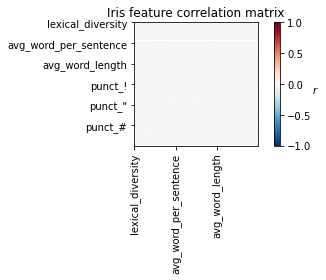

In [47]:
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
feature_names = X_train.columns.values.tolist()

X = StandardScaler().fit_transform(X_train)

ax = plt.axes()

im = ax.imshow(np.corrcoef(X.T), cmap="RdBu_r", vmin=-1, vmax=1)

#ax.set_xticks([0, 1, 2, 3])
#ax.set_xticklabels(feature_names, rotation=90)
#ax.set_yticks([0, 1, 2, 3])
#ax.set_yticklabels(list(feature_names))

plt.colorbar(im).ax.set_ylabel("$r$", rotation=0)
ax.set_title("Feature correlation matrix")
plt.tight_layout()


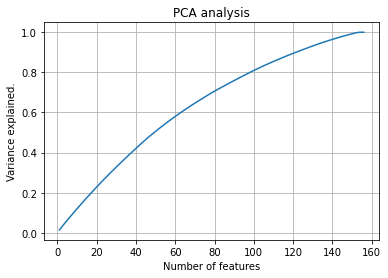

In [44]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt


feature_names = X_train.columns.values.tolist()

pca = PCA(n_components=min(len(feature_names), len(X_train.index)))
pca.fit_transform(X)

fig, ax = plt.subplots()
var_explained = pca.explained_variance_ratio_.cumsum()
components = [i+1 for i in range(len(var_explained))]
ax.plot(components, var_explained)


ax.set(xlabel='Number of features', ylabel='Variance explained.',
       title='PCA analysis')
ax.grid()

fig.savefig("pca_analysis.png")
plt.show()
